<a href="https://colab.research.google.com/github/sergfer26/Proyectos-II/blob/main/semana5/clase14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de digitos escritos a mano usando redes neuronales convolucionales (CNNs)

En esta clase aprenderemos como diseñar y entrenar la popular red neuronal convolucional **LeNet** en Pytorch para clasificar imágenes. Usaremos el conjunto de imágenes de dígitos escritos a mano MNIST. Este conjunto de datos consta de $60,000$ imágenes de entrenamiento  y $10, 000$ imágenes de prueba. Estas imágenes son de $10$ dígitos de $0,1,2, 3, 4, 5, 6, 7, 8$ y $9$, estan uniformemente distribuidas.

**Objetivo:** Diseñar y entrenar el modelo *LeNet* con la meta de ser capaz de reconocer (clasificar) los digitos que aparecen en el conjunto MNIST. 

In [ ]:
import torch 
import time
import matplotlib 
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

## Carga de conjunto de datos
Usaremos la biblioteca torchvison que es parte de todo el proyecto de pytorch. Esta biblioteca reune datasets populares, modelos de redes neuronales preentrenados y diversas herramientas para visión por computadora. De esta biblioteca descargaremos el conjunto MNIST. Para revisar la documentación favor de visitar su sitio.

<img src='https://drek4537l1klr.cloudfront.net/elgendy/v-3/Figures/05_01.png'>

In [ ]:
import torchvision # módulo para manipular o transformar imágenes
from torchvision import transforms
from torchvision.datasets import MNIST

my_transform = transforms.Compose([
    transforms.ToTensor(), 
    #transforms.Normalize((0.5,),(0.5,)),
    #transform.Lambda(lambda x: torch.flatten(x))
])

train_set = MNIST('PATH_TO_STORE_TRAINSET', 
                         download=True, train=True, transform=my_transform)

test_set_ = MNIST('PATH_TO_STORE_TESTSET', 
                         download=True, train=False, transform=my_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



In [ ]:
n_train = len(train_set)
print('Se tienen {} de datos de entrenamiento'.format(n_train))
print('Se tienen {} de datos de prueba'.format(len(test_set_)))

Se tienen 60000 de datos de entrenamiento
Se tienen 10000 de datos de prueba


## Dataset

Ahora dividiremos `test_set` en dos par tener imágenes que podamos usar de validación en el entrenamiento.

In [ ]:
val_size = 0.5 # parte para validar
n = len(test_set_)
indices = list(range(n))
np.random.shuffle(indices) # revolvemos los indices
split = int(np.floor(val_size * n)) 
test_idx, val_idx = indices[split:], indices[:split] # seprarmos los indices

test_set = torch.utils.data.Subset(test_set_, test_idx) # tomamos un subconjunto de acuerdo a los indices
val_set = torch.utils.data.Subset(test_set_, val_idx)
n_test = len(test_set)
n_val = len(val_set) 

## Dataloader


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=256, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=n_test, shuffle=False)

## Exploración y análisis de las imágenes

En esta sección haremos una exploración y análisis de las imagenes de nuestro conjunto de datos. En la siguiente instrucción desempaquetamos las etiquetas y las imagenes del conjunto de entrenamiento.

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [ ]:
print('(n_batch, # de canales, px, px) : ',images.shape)
print('n_batch : {}'.format(labels.shape[0]))

(n_batch, # de canales, px, px) :  torch.Size([256, 1, 28, 28])
n_batch : 256


dígito:  3


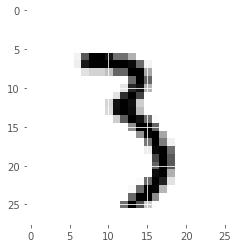

In [ ]:
index = 10
plt.imshow(images[index].numpy().squeeze(), cmap='gray_r'); 
print('dígito: ',int(labels[index]))

## Definición de la arquitectura de la red Arquitectura de la red


 Sea $f_a(\cdot |\theta): \mathbb{R}^{k \times 1 \times 28 \times 28}\rightarrow \mathbb{R}^{k \times 10}$ con $$a=\left(\langle \text{Conv}(1, 6, k=5, p=2), \text{Sigmoid}, \text{AvgPool}(k=2, s=2), \text{Conv}(6, 16, k=5), \text{Sigmoid}, \text{AvgPool}(k=2, s=2)\rangle\cup\langle [784, 512, 512, 10], \{\text{ReLU, ReLU, Linear}\}\rangle\right)$$
la red neuronal que usaremos para la tarea de clasificación. 


El modelo completo esta dado por la siguiente expresión: 
$$\text{Softmax}\circ f(\cdot|\theta): \mathbb{R}^{k \times 1 \times 28 \times 28} \rightarrow [0, 1]^{10}.$$

In [ ]:
from collections import OrderedDict

c = 1 # canales de la imagen
n_class = 10
# define the architecture of LeNet
classifier = nn.Sequential(OrderedDict([
    ('z1', nn.Conv2d(c, 6, kernel_size=5, padding=2)),
    ('h1', nn.Sigmoid()),
    ('p1', nn.AvgPool2d(kernel_size=2, stride=2)),
    ('z2', nn.Conv2d(6, 16, kernel_size=5)),
    ('h2', nn.Sigmoid()),
    ('p2', nn.AvgPool2d(kernel_size=2, stride=2)), # Aquí termina la parte convolucional
    ('f2', nn.Flatten()),
    ('z3', nn.Linear(16 * 5 * 5, 120)), # Feed forward fully connected
    ('h3', nn.Sigmoid()),
    ('z4', nn.Linear(120, 84)),
    ('h4', nn.Sigmoid()),
    ('z5', nn.Linear(84, 10)),
  ]))

In [ ]:
x = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in classifier:
  x = layer(x)
  print(layer.__class__.__name__, 'output shape: \t', x.shape)

Conv2d output shape: 		 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 		 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 		 torch.Size([1, 6, 14, 14])
Conv2d output shape: 		 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 		 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 		 torch.Size([1, 16, 5, 5])
Flatten output shape: 		 torch.Size([1, 400])
Linear output shape: 		 torch.Size([1, 120])
Sigmoid output shape: 		 torch.Size([1, 120])
Linear output shape: 		 torch.Size([1, 84])
Sigmoid output shape: 		 torch.Size([1, 84])
Linear output shape: 		 torch.Size([1, 10])


## CPU vs GPU
Pytorch permite hacer uso del CPU de forma predeterminda o GPU, si este existe y el usario selecciona la opción de usarlo. Para hacer uso del GPU sólo es necesario ejecutar la instrucción siguiente:

In [ ]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

print(device)

cuda



Nota: Si no se tiene CPU se dejará indicado que se usará el CPU. Si no se quiere usar el GPU basta con omitir la instrucción anterior salvo la indicación device = "cpu".

Es necesario guardar a los tensores que estemos ussando en el gpu. Esta acción la efectuamos al usar el método `.to(device)` en cada tensor que usemos.

In [ ]:
print('x= ', x)
x_gpu = x.to(device)
print('x_gpu= ',x_gpu)

x=  tensor([[-0.1181, -0.1768, -0.1429, -0.2546, -0.1869, -0.1495, -0.1635, -0.2452,
          0.5220,  0.3163]], grad_fn=<AddmmBackward>)
x_gpu=  tensor([[-0.1181, -0.1768, -0.1429, -0.2546, -0.1869, -0.1495, -0.1635, -0.2452,
          0.5220,  0.3163]], device='cuda:0', grad_fn=<CopyBackwards>)


En particular deberemos de transformar cada uno de los elementos de los conjuntos de datos y todos los parámetros de la red neuronal. La primera transformación la podemos efectuar dentro del entrenamiento y el segundo lo haremos en la siguiente instrucción.

In [ ]:
classifier = classifier.to(device)

## Función objetivo y optimizador
* Función objetivo: [Categorical Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
* Optimizador: [RMSPROP](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html).

In [ ]:
criterion = nn.CrossEntropyLoss()
params = classifier.parameters()
optimizer = torch.optim.RMSprop(params, lr=0.001, alpha=0.9, eps=1e-07, weight_decay=0, momentum=0, centered=False)

## Entrenamiento

1. Paso de entrenamiento por época (*epoch*).

In [ ]:
import torch.nn.functional as F

def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    X = X.to(device) # Por si hay gpu
    Y = Y.to(device) # Por si hay gpu
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(Y.shape[0])
  return avg_loss, acc

2. Ciclo de entrenamiento

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs=20):
  train_time = 0
  epoch_loss = list(); epoch_acc = list()
  val_loss = list(); val_acc = list()

  n_train = len(train_loader.dataset)
  n_val = len(val_loader.dataset)
  model.train() # -> aplica drop si lo tiene el modelo y lleva registro de los gradientes
  for epoch in range(epochs):
    start_time = time.time()
    with tqdm(total=n_train, position=0) as pbar_train:
      pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - train')
      pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
      loss_train, acc_train = fit(model, train_loader, optimizer, criterion, pbar_train)
      train_time +=  time.time() - start_time
    model.eval() # -> de esta forma no incluye dropout, ni lleva registro de los gradientes
    with tqdm(total=n_val, position=0) as pbar_val:
      pbar_val.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - val')
      pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
      loss_val, acc_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)

    val_loss.append(loss_val)
    val_acc.append(acc_val)

  return epoch_loss, epoch_acc, val_loss, val_acc, train_time

In [ ]:
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(classifier, train_loader, val_loader, optimizer, criterion)
print("\n --- %s seconds ---", train_time)

Epoch 20/20 - val: 100%|██████████| 5000/5000 [00:00<00:00, 5082.92it/s, acc=0.9728, avg_loss=0.0869]


 --- %s seconds --- 269.8196713924408


### Evaluación del entrenamiento 

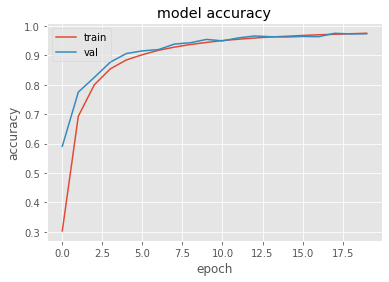

In [ ]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

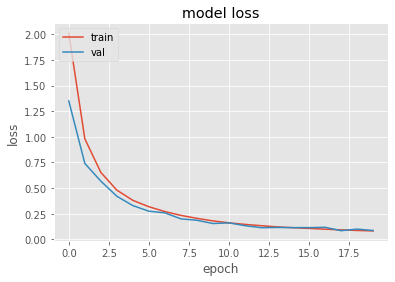

In [ ]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Prueba del modelo

In [ ]:
def test(model, test_loader):
  total = len(test_loader.dataset)
  X, Y = next(iter(test_loader))
  X = X.to(device)
  Y = Y.to(device)
  pred = model(X) # forward pass 
  loss = criterion(pred, Y) # evaluación de predicción
  probs = F.softmax(pred, 1)
  label = torch.argmax(probs, dim=1)
  correct = torch.sum(label == Y).item()
  acc = correct/total
  return loss.item(), acc

In [ ]:
loss, acc = test(classifier, test_loader)
print('modelo simple: loss ={}, acc= {}'.format(loss, acc))

modelo simple: loss =0.09219028055667877, acc= 0.9736
